# Nordhaus OE PRIM

In [1]:
from IPython import get_ipython
import time
import copy
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators


import os
from dest_directories import gz_path, fig_path
from dicemodel.specs import change_fontsize
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'




In [2]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results

from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import pairs_plotting, plotting, plotting_util

import ema_workbench.em_framework.evaluators
from dicemodel.specs import change_fontsize, nordhaus_policy
# from ema_workbench.analysis import feature_scoring
# from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# from SALib.analyze import sobol

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [3]:

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600),
                             RealParameter('emdd', -1, 0.99),
                             IntegerParameter('vd_switch', 0, 1),                             
                            ]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('emuc',  1.01, 2.00),
                    #   IntegerParameter('vd_switch', 0, 1),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]
    
    dice_sm.outcomes = [
                        TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        # TimeSeriesOutcome('Undiscounted Period Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR'),
                        TimeSeriesOutcome('SCC')
                        ]



In [8]:
# n_scenarios = 2000
# n_policies = 50
# run = '36_OE'
n_scenarios = 100000
n_policy = 1
run = '39_NordOE'



In [9]:
## Load results
results = load_results(os.path.join(gz_path,'run_35_NordOE_v7_100000s_.tar.gz'))
experiments, outcomes = results



[MainProcess/INFO] results loaded succesfully from E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\run_35_NordOE_v7_100000s_.tar.gz


In [10]:
# Clean experiments 
# (keep only levers, remove policy, scenario, model columns)
cleaned_experiments = experiments.drop(labels=[l.name for l in dice_sm.uncertainties], axis=1)
cleaned_experiments = experiments.drop(labels= ['policy', 'model',] , axis=1)
x = cleaned_experiments
#  For y: outcomes is nd-array, PRIM needs 1D

In [11]:
# Clean outcomes
# dropping first two steps (warm up) and last five steps(cooldown)
cleaned_outcome = {}
for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape

(100000, 58)

In [12]:
# values for 2300 
end_outcome = {}
for key, value in outcomes.items():
    end_outcome[key] = value[:, -1]  

# np.mean(end_outcome['Damage Growth'], axis =0)


In [13]:
import copy
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)

In [16]:
y_output_bottom20 = data_output < np.percentile(data_output, 20) # what causes the least values (bottom 20th percentile) of this outcome


In [17]:

x = cleaned_experiments
y = y_output_bottom20

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim



In [18]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 20000 cases of interest
[MainProcess/INFO] mean: 0.7179777400490474, mass: 0.05301, coverage: 0.1903, density: 0.7179777400490474 restricted_dimensions: 2


,coverage,density,id,mass,mean,res_dim
0,1.00000,0.200000,0,1.00000,0.200000,0
1,0.99970,0.222601,1,0.89820,0.222601,1
2,0.99805,0.247535,2,0.80639,0.247535,1
3,0.98755,0.272597,3,0.72455,0.272597,1
4,0.96950,0.297987,4,0.65070,0.297987,1
5,0.94830,0.324299,5,0.58483,0.324299,1
6,0.92130,0.351005,6,0.52495,0.351005,1
7,0.89230,0.378848,7,0.47106,0.378848,1
8,0.85865,0.405828,8,0.42316,0.405828,1
9,0.82530,0.435239,9,0.37924,0.435239,1


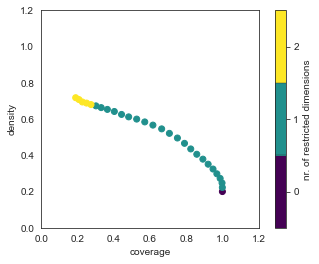

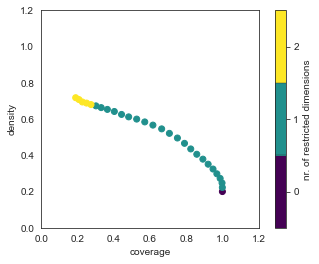

In [19]:
box1.show_tradeoff()

In [20]:
box1.inspect(10)

coverage     0.79085
density     0.466138
id                10
mass         0.33932
mean        0.466138
res_dim            1
Name: 10, dtype: object

      box 10                    
         min    max    qp values
cback  430.5  600.0  [0.0, -1.0]



## Welfare

In [ ]:
import copy
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)

 bottom 20

In [14]:
# Welfare
# y_welfare = end_outcome['Welfare'] < 5000
y_welfare_low20 = end_outcome['Welfare'] < np.percentile(end_outcome['Welfare'], 20)


In [15]:

x = cleaned_experiments
y = y_welfare_low20

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)

In [16]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 20000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.09261, coverage: 0.46305, density: 1.0 restricted_dimensions: 2


,coverage,density,id,mass,mean,res_dim
0,1.00000,0.200000,0,1.00000,0.200000,0
1,1.00000,0.400000,1,0.50000,0.400000,1
2,1.00000,0.444444,2,0.45000,0.444444,2
3,1.00000,0.493827,3,0.40500,0.493827,2
4,1.00000,0.548697,4,0.36450,0.548697,2
5,1.00000,0.609663,5,0.32805,0.609663,2
6,1.00000,0.677415,6,0.29524,0.677415,2
7,0.99975,0.752512,7,0.26571,0.752512,2
8,0.95550,0.799147,8,0.23913,0.799147,2
9,0.90860,0.844385,9,0.21521,0.844385,2


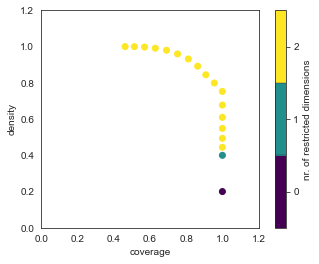

In [17]:
box1.show_tradeoff()
fig = plt.gcf()
# fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_wel_tradeoff' + '.png'))

In [22]:
box1.inspect(11)

coverage      0.8121
density     0.931788
id                11
mass         0.17431
mean        0.931788
res_dim            2
Name: 11, dtype: object

             box 11                       
                min       max    qp values
emdd      -0.999998 -0.305681  [-1.0, 0.0]
vd_switch  0.500000  1.000000  [0.0, -1.0]



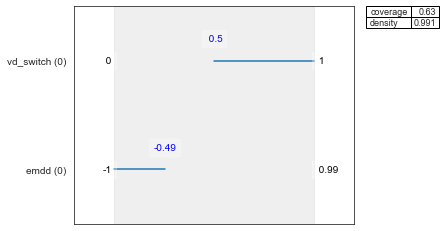

In [24]:
box1.inspect(14, style='graph')
fig = plt.gcf()
# fig.set_size_inches(12,12)
fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_wel_id11' + '.png'))

plt.show()

 emdd range up to -0.3 causes bottom 20% of welfare outcomes

## Disutility of Damage

In [28]:
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)


In [29]:

# Disutility of Damage, undesirable threshold: highest 20% values
data_damage = np.amax(y['Disutility of Damage'], axis=1)
y_vd_high20 = data_damage > np.percentile(data_damage, 80)

In [30]:

x = cleaned_experiments
y = y_vd_high20

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1) #0.1 

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim



In [31]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 20000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.12706, coverage: 0.6353, density: 1.0 restricted_dimensions: 2


,coverage,density,id,mass,mean,res_dim
0,1.00000,0.200000,0,1.00000,0.200000,0
1,1.00000,0.400000,1,0.50000,0.400000,1
2,1.00000,0.444444,2,0.45000,0.444444,2
3,1.00000,0.493827,3,0.40500,0.493827,2
4,1.00000,0.548697,4,0.36450,0.548697,2
5,1.00000,0.609663,5,0.32805,0.609663,2
6,1.00000,0.677415,6,0.29524,0.677415,2
7,1.00000,0.752700,7,0.26571,0.752700,2
8,0.99535,0.832476,8,0.23913,0.832476,2
9,0.96740,0.899029,9,0.21521,0.899029,2


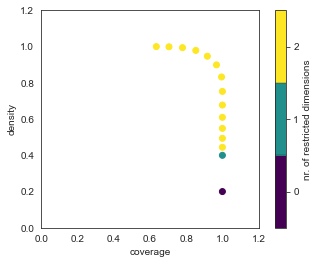

In [32]:
box1.show_tradeoff()
fig = plt.gcf()
fig.savefig(os.path.join(fig_path,str(run) + '_PRIM_VD_tradeoff' + '.png'))

In [36]:
box1.inspect(11)

coverage     0.85315
density     0.978888
id                11
mass         0.17431
mean        0.978888
res_dim            2
Name: 11, dtype: object

             box 11                       
                min       max    qp values
emdd      -0.999998 -0.305681  [-1.0, 0.0]
vd_switch  0.500000  1.000000  [0.0, -1.0]



emdd up to -0.3 also the cause for highest 20% V(D), corresponding to lowest 20% Welfare outcomes

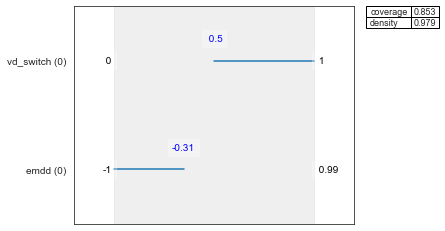

In [37]:
box1.inspect(11, style='graph')
plt.show()


## Per Capita Damage

In [42]:
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)


In [43]:

# Per capita Damage, undesirable threshold: highest 20% values
data_damage = np.amax(y['Per Capita Damage'], axis=1)
y_dpc_high20 = data_damage > np.percentile(data_damage, 80)


In [46]:

x = cleaned_experiments
y = y_dpc_high20

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)

In [47]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 20000 cases of interest


ValueError: ('n must be >= x', 'occurred at index pop_gr')

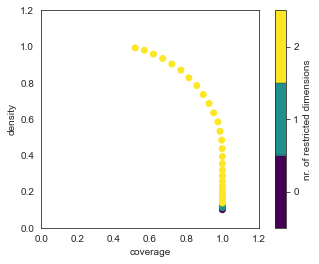

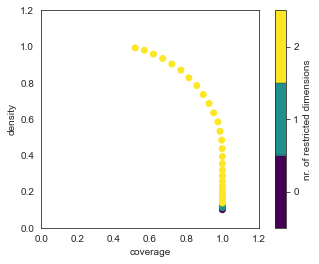

In [43]:
box1.show_tradeoff()

In [44]:
box1.inspect(22)

coverage       0.815
density     0.827915
id                22
mass         0.09844
mean        0.827915
res_dim            2
Name: 22, dtype: object

         box 22                       
            min       max    qp values
pop_gr    0.100  0.126408  [-1.0, 0.0]
sigma_gr -0.012 -0.011264  [-1.0, 0.0]



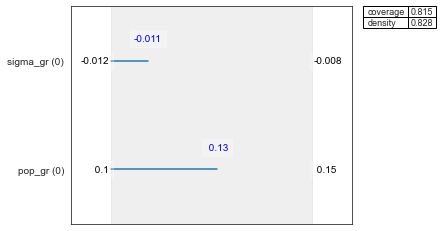

In [45]:
box1.inspect(22, style='graph')
plt.show()


# Results so far

 emdd range up to -0.5 causes bottom 20% of welfare outcomes
 Bottom 80% of damage outcomes caused by sigma_gr (-0.012, -0.008)
 Bottom 20% of damage outcomes caused by same sigma_gr range + pop_gr (0.1, 0.12) --> low population groth rates in conjunction with low sigma_gr leads to the low damage outcomes, not vd or emdd

 sigma_gr = Decline of decarbonization (per period). It's rate of decline is FIXED AT 1%, AND NOT EVEN TREATED AS AN UNCNERTAINTY WITH A RANGE

 Now, we check for bottom 5% just to be sure

In [46]:
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)


In [47]:

# Per capita Damage
data_damage = np.amax(y['Per Capita Damage'], axis=1)
y_dpc5 = data_damage < np.percentile(data_damage, 5)

In [48]:

x = cleaned_experiments
y = y_dpc5

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim



In [49]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 5000 cases of interest
[MainProcess/INFO] mean: 0.8009179575444636, mass: 0.05229, coverage: 0.8376, density: 0.8009179575444636 restricted_dimensions: 2


,coverage,density,id,mass,mean,res_dim
0,1.0000,0.050000,0,1.00000,0.050000,0
1,1.0000,0.055556,1,0.90000,0.055556,1
2,1.0000,0.061728,2,0.81000,0.061728,1
3,1.0000,0.068587,3,0.72900,0.068587,1
4,1.0000,0.076208,4,0.65610,0.076208,1
5,1.0000,0.084675,5,0.59049,0.084675,1
6,1.0000,0.094084,6,0.53144,0.094084,2
7,1.0000,0.104539,7,0.47829,0.104539,2
8,1.0000,0.116155,8,0.43046,0.116155,2
9,1.0000,0.129062,9,0.38741,0.129062,2


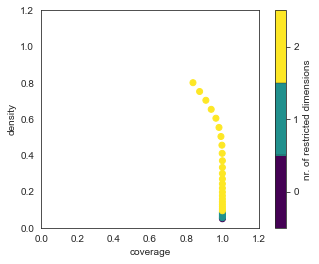

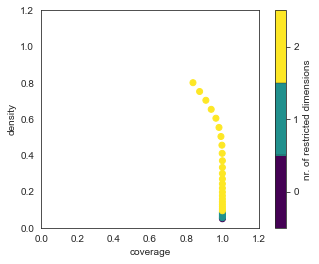

In [50]:
box1.show_tradeoff()

In [51]:
box1.inspect(28)

coverage      0.8376
density     0.800918
id                28
mass         0.05229
mean        0.800918
res_dim            2
Name: 28, dtype: object

         box 28                       
            min       max    qp values
pop_gr    0.100  0.117330  [-1.0, 0.0]
sigma_gr -0.012 -0.011403  [-1.0, 0.0]



 Bottom 5% also same as bottom 10.

# PRIM on V(D)

In [52]:
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)


In [53]:
# Disutility of Damage

data_disutil_dam = np.max(cleaned_outcome['Disutility of Damage'], axis = 1)
y_disutil_dam_top80 = data_disutil_dam < np.percentile(data_disutil_dam, 80)
# y_disutil_dam10 = end_outcome['Disutility of Damage'] > np.percentile(end_outcome['Disutility of Damage'], 10)

###### by percentile
# #percentile < 80 = bottom 80

In [54]:

x = cleaned_experiments
y = y_disutil_dam_top80

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim



In [55]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 80000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.5, coverage: 0.625, density: 1.0 restricted_dimensions: 1


,coverage,density,id,mass,mean,res_dim
0,1.000,0.8,0,1.0,0.8,0
1,0.625,1.0,1,0.5,1.0,1


In [56]:
box1.inspect(1)

coverage    0.625
density         1
id              1
mass          0.5
mean            1
res_dim         1
Name: 1, dtype: object

          box 1                  
            min  max    qp values
vd_switch   0.0  0.5  [-1.0, 0.0]



In [57]:
# Disutility of Damage

data_disutil_dam = np.max(cleaned_outcome['Disutility of Damage'], axis = 1)
y_disutil_dam_top20 = data_disutil_dam > np.percentile(data_disutil_dam, 80)
# y_disutil_dam10 = end_outcome['Disutility of Damage'] > np.percentile(end_outcome['Disutility of Damage'], 10)

###### by percentile
# #percentile < 80 = bottom 80

In [58]:

x = cleaned_experiments
y = y_disutil_dam_top20

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim



In [59]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 20000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.12706, coverage: 0.6353, density: 1.0 restricted_dimensions: 2


,coverage,density,id,mass,mean,res_dim
0,1.00000,0.200000,0,1.00000,0.200000,0
1,1.00000,0.400000,1,0.50000,0.400000,1
2,1.00000,0.444444,2,0.45000,0.444444,2
3,1.00000,0.493827,3,0.40500,0.493827,2
4,1.00000,0.548697,4,0.36450,0.548697,2
5,1.00000,0.609663,5,0.32805,0.609663,2
6,1.00000,0.677415,6,0.29524,0.677415,2
7,1.00000,0.752700,7,0.26571,0.752700,2
8,0.99535,0.832476,8,0.23913,0.832476,2
9,0.96740,0.899029,9,0.21521,0.899029,2


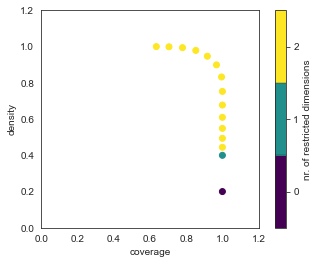

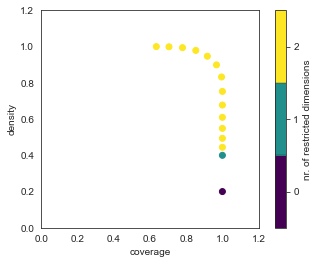

In [60]:
box1.show_tradeoff()

In [61]:
box1.inspect(9)

coverage      0.9674
density     0.899029
id                 9
mass         0.21521
mean        0.899029
res_dim            2
Name: 9, dtype: object

              box 9                       
                min       max    qp values
emdd      -0.999998 -0.142818  [-1.0, 0.0]
vd_switch  0.500000  1.000000  [0.0, -1.0]



In [62]:
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)


In [64]:
# Disutility of Damage

data_disutil_dam = np.max(cleaned_outcome['Disutility of Damage'], axis = 1)
# y_disutil_dam_top20 = data_disutil_dam > np.percentile(data_disutil_dam, 80)
y_disutil_dam_gr2 = data_disutil_dam > 2
# y_disutil_dam10 = end_outcome['Disutility of Damage'] > np.percentile(end_outcome['Disutility of Damage'], 10)

###### by percentile
# #percentile < 80 = bottom 80

In [65]:

x = cleaned_experiments
y = y_disutil_dam_gr2

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim



In [66]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 6034 cases of interest
[MainProcess/INFO] mean: 0.8646423998536674, mass: 0.05467, coverage: 0.7833941000994366, density: 0.8646423998536674 restricted_dimensions: 3


,coverage,density,id,mass,mean,res_dim
0,1.000000,0.060340,0,1.00000,0.060340,0
1,1.000000,0.120680,1,0.50000,0.120680,1
2,1.000000,0.134089,2,0.45000,0.134089,2
3,1.000000,0.148988,3,0.40500,0.148988,2
4,1.000000,0.165542,4,0.36450,0.165542,2
5,1.000000,0.183935,5,0.32805,0.183935,2
6,1.000000,0.204376,6,0.29524,0.204376,2
7,1.000000,0.227090,7,0.26571,0.227090,2
8,1.000000,0.252331,8,0.23913,0.252331,2
9,1.000000,0.280377,9,0.21521,0.280377,2


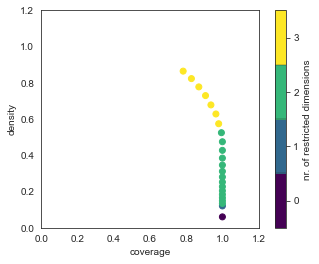

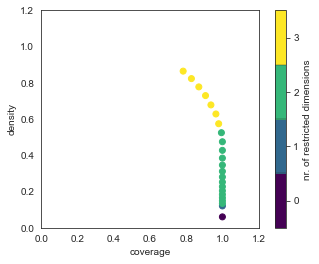

In [67]:
box1.show_tradeoff()

In [68]:
box1.inspect(19)

coverage    0.906861
density       0.7296
id                19
mass           0.075
mean          0.7296
res_dim            3
Name: 19, dtype: object

             box 19                                         
                min       max                      qp values
emdd      -0.999998 -0.630684                    [-1.0, 0.0]
vd_switch  0.500000  1.000000                    [0.0, -1.0]
sigma_gr  -0.011202 -0.008000  [7.596037988816198e-91, -1.0]



In [69]:
y = copy.deepcopy(cleaned_outcome)
y_end = copy.deepcopy(end_outcome)


In [70]:
# Disutility of Damage

data_disutil_dam = np.max(cleaned_outcome['Disutility of Damage'], axis = 1)
# y_disutil_dam_top20 = data_disutil_dam > np.percentile(data_disutil_dam, 80)
y_disutil_dam_gr3 = data_disutil_dam > 3
# y_disutil_dam10 = end_outcome['Disutility of Damage'] > np.percentile(end_outcome['Disutility of Damage'], 10)

###### by percentile
# #percentile < 80 = bottom 80

In [71]:

x = cleaned_experiments
y = y_disutil_dam_gr3

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1) #0.1 

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.
# from ema_workbench.analysis import prim



In [72]:
box1 = prim_alg.find_box()
box1.peeling_trajectory

[MainProcess/INFO] 100000 points remaining, containing 195 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.03566855679531736, returning dump box


,coverage,density,id,mass,mean,res_dim
0,1.0,0.00195,0,1.0,0.00195,0
